# TikTok Data Exploration

Using the data collected from the crawler, we will run Exploratory Data Analysis (EDA).

Table of contents:

- Helper Functions
- Unemployment Data Exploration
- Stimulus Check Data Exploration
- USPS Data Exploration
- Topic Modeling
- Sentiment Analysis
- Document Summarization Model

In [67]:
'''@author: osamah Abdelhaq last edit: 6/24/2020'''

'@author: osamah Abdelhaq last edit: 6/24/2020'

## Requirements

Dataframe stored in pickle form, collected through the crawler and passed through the preprocessing script.

Libraries:

- NLTK
- Wordcloud
- Textblob
- Seaborn
- Pandas
- Plotly
- Matplotlib
- Sci-kit Learn
- Sci-py
- Gensim

In [2]:
#import packages/libraries

from nltk.tokenize.casual import TweetTokenizer
from itertools import chain #to unnest lists
from nltk import ngrams, word_tokenize, pos_tag
import nltk
import pickle
t = TweetTokenizer()
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)
from sklearn.feature_extraction import text
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS

from nltk import *
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from scipy import stats
import seaborn as sns

import gensim
from gensim import matutils, models, corpora
import scipy.sparse

## Import Data

In [3]:
# Load DataFrame with pickle object
unemployment_frame = pd.read_pickle('unemployment_tiktok_dataframe.p')

usps_frame = pd.read_pickle('usps_tiktok_dataframe.p')

stimulus_frame = pd.read_pickle('stimulus_tiktok_dataframe.p')

## Helper Functions

In [4]:
def lexical_diversity(text):
    '''returns percentage representing lexical diversity of the text'''
    return(len(set(text))/len(text))

In [5]:
def prep(frame):
    '''input: column of dataframe
    output: returns nested list of tokenized, lemmatized words with stop words removed'''

    stop_words = set(stopwords.words('english'))
    lem = nltk.WordNetLemmatizer()
    
    #lemmatize words
    #lowercase words
    #remove stop words
    tokens = []
    for i in frame:
        sentence = []
        
        #lemmatize based on the pos
        # Get the single character pos constant from pos_tag like this:
        tik = t.tokenize(i)
        for tok in tik:
            pos_label = (pos_tag(tok)[0][1][0]).lower()

            # pos_refs = {'n': ['NN', 'NNS', 'NNP', 'NNPS'],
            #            'v': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
            #            'r': ['RB', 'RBR', 'RBS'],
            #            'a': ['JJ', 'JJR', 'JJS']}
            
            if pos_label == 'j': pos_label = 'a'    # 'j' <--> 'a' reassignment

            if pos_label in ['r']:  # For adverbs it's a bit different
                try:
                    s = wordnet.synset(tok+'.r.1').lemmas()[0].pertainyms()[0].name()
                except:
                    s = tok
                    continue

            elif pos_label in ['a', 's', 'v']: # For adjectives and verbs
                try:
                    s = lem.lemmatize(tok, pos=pos_label)
                except:
                    s = tok
                    continue

            else:   # For nouns and everything else as it is the default kwarg
                try:
                    s = lem.lemmatize(tok)
                except:
                    s = tok
                    continue

            if s not in stop_words:
                #tokenize
                sentence.append(s)
            else:
                del s
            
        tokens.append(sentence)

    return tokens

In [6]:
def alph(frame):      
    '''input: takes a nested list of tokenized words
    output: returns unnested list of tokens with letters, emojis, and punctuation removed.
    Only alphabetical characters greater than length 4 are returned'''
    #unnest list
    unlist = list(chain(*frame))

    #remove anything non alphabetical and append to une_alph
    regex = re.compile('[^a-zA-Z]')
    
    alph = []
    
    #only keep words greater than 4 letters long
    for i in unlist:
        if (len(i) > 4 and i != ", "):
            alph.append(regex.sub('', i))
            
    return alph

In [7]:
def freqChart(alph):
    '''Input: word list, not nested, of only alphabetical words
    Output: returns word frequency list(l) and graph of top 20 words (f)
    returns least common words (u)
    '''
    
    #create frequency distribution of words
    fdist1 = FreqDist(alph)
    
    #ten most common words
    l = fdist1.most_common(10)
    
    #frequency distribution chart of top 20 words
    f = fdist1.plot(20, cumulative=True)
    
    #10 most infrequent words
    u = fdist1.hapaxes()
    
    return l, u[:10], f

In [8]:
def plot_word_cloud(alph):
    '''input: word list, not nested, of only alphabetical words
    output: plots word cloud'''
    str_Cloud = " ".join(alph)
    
    wc = WordCloud(# font_path='simsun.ttf',  
               background_color="white",  
               width=600,height=300,
               min_font_size=10,
               stopwords=STOPWORDS,
               max_words=2000,  
               # mask=back_coloring, 
               max_font_size=120, 
               random_state=42,
               collocations=False,
               colormap = 'cool').generate(str_Cloud)
    # image_colors = ImageColorGenerator(back_coloring)
    plt.figure(figsize=(60,30))
    plt.imshow(wc)
    plt.axis("off")
    # plt.savefig("word_cloud.jpeg")
    plt.show()

In [9]:
def polplot(df, threshold):
    '''Input: polarization column and thresholds list [positive threshold, negative threshold]
    Output: Pie chart of polarization'''
    
    # Data to plot
    #parameter is threshold of subjectivity
    positive_threshold = threshold[0]
    negative_threshold = threshold[1]
    
    negative = 0
    neutral = 0
    positive = 0
    
    #adding count to subjective or objective depending on threshold
    for i in df:
        if (i >= positive_threshold):
            positive += 1
        elif (i <= negative_threshold):
            negative += 1
        else:
            neutral += 1
    
    counts=[negative, neutral, positive]
    
    labels = 'Negative', 'Neutral', 'Positive'
    colors = ['lightcoral', 'gray', 'lightskyblue']
    explode = (0.1, 0.07, 0.1)  # explode 1st and 3rd slice

    # Plot
    plt.pie(counts, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

In [10]:
def subpie(df, threshold):
    '''Input: subjectivity column and threshold
    Output: Pie chart of subjectivity'''
    
    # Data to plot
    #parameter is threshold of subjectivity
    threshold = threshold
    
    subjective = 0
    objective = 0
    #adding count to subjective or objective depending on threshold
    for i in df:
        if (i >= threshold):
            subjective += 1
        elif (i < threshold):
            objective += 1
    
    counts=[subjective, objective]
    
    labels = 'Opinion', 'Fact'
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # explode 1st slice

    # Plot
    plt.pie(counts, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

# Unemployment Data Exploration

In [11]:
'''gather basic information'''

print(unemployment_frame.info())

#preview data
print(unemployment_frame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 3 columns):
name    1898 non-null object
text    1898 non-null object
date    1898 non-null object
dtypes: object(3)
memory usage: 44.6+ KB
None
                          name  \
0         Heather MacIvor Moul   
1                        Peace   
2         Heather MacIvor Moul   
3  Cathryn Patterson · Creator   
4            user1156407460130   

                                                text  date  
0                         cannot hear you bc lashes.   4-8  
1  If you close your eyes they turn all the way d...   4-8  
2                                          good tip!  4-13  
3                                         thank you!  4-13  
4  Lol stop she’s giving good tips and looks so g...  4-19  


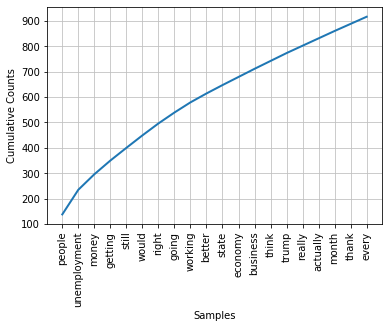

AxesSubplot(0.125,0.125;0.775x0.755)
Top Ten Most Common Words: [('people', 138), ('unemployment', 97), ('money', 61), ('getting', 54), ('still', 50), ('would', 49), ('right', 47), ('going', 43), ('working', 40), ('better', 35)]
Ten Least Common Words: ['Morse', 'Lmfao', 'Hahahhahah', 'Someone', 'ccalex', 'SCREAMING', 'hahahaahah', 'LOLOLOLOLOL', 'LMAOOO', 'slaying']
lexical diversity:  0.3560660445082556


In [12]:
'''word frequency analysis'''
#tokenize, lowercase, lemmatize, remove stop words
une_tokens = prep(unemployment_frame['text'])

#add tokens as a new column ('text_prep') to dataframe
unemployment_frame['text_prep'] = une_tokens

#remove anything not alphabetical
une_alph = alph(une_tokens)

#fetch word frequencies
une_freq_list, une_not_freq_list, une_freq_chart = freqChart(une_alph)

#print results
print(une_freq_chart)
print('Top Ten Most Common Words:',une_freq_list)
print('Ten Least Common Words:',une_not_freq_list)
print('lexical diversity: ',lexical_diversity(une_alph))

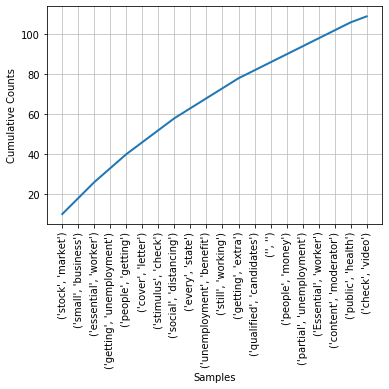

AxesSubplot(0.125,0.125;0.775x0.755)


In [13]:
'''word frequency analysis with bigrams'''

#repeat but with bigrams for more insight
une_bigrams = list(nltk.bigrams(une_alph))
une_bigrams_freq_list, une_bigrams_uncommon, une_bigrams_graph = freqChart(une_bigrams)
print(une_bigrams_graph)

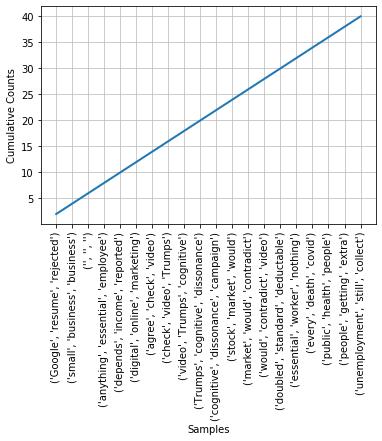

AxesSubplot(0.125,0.125;0.775x0.755)


In [14]:
'''word frequency analysis with trigrams'''

#repeat but with trigrams for more insight
une_trigrams = list(nltk.trigrams(une_alph))
une_trigrams_freq_list, une_trigrams_uncommon, une_trigrams_graph = freqChart(une_trigrams)
print(une_trigrams_graph)

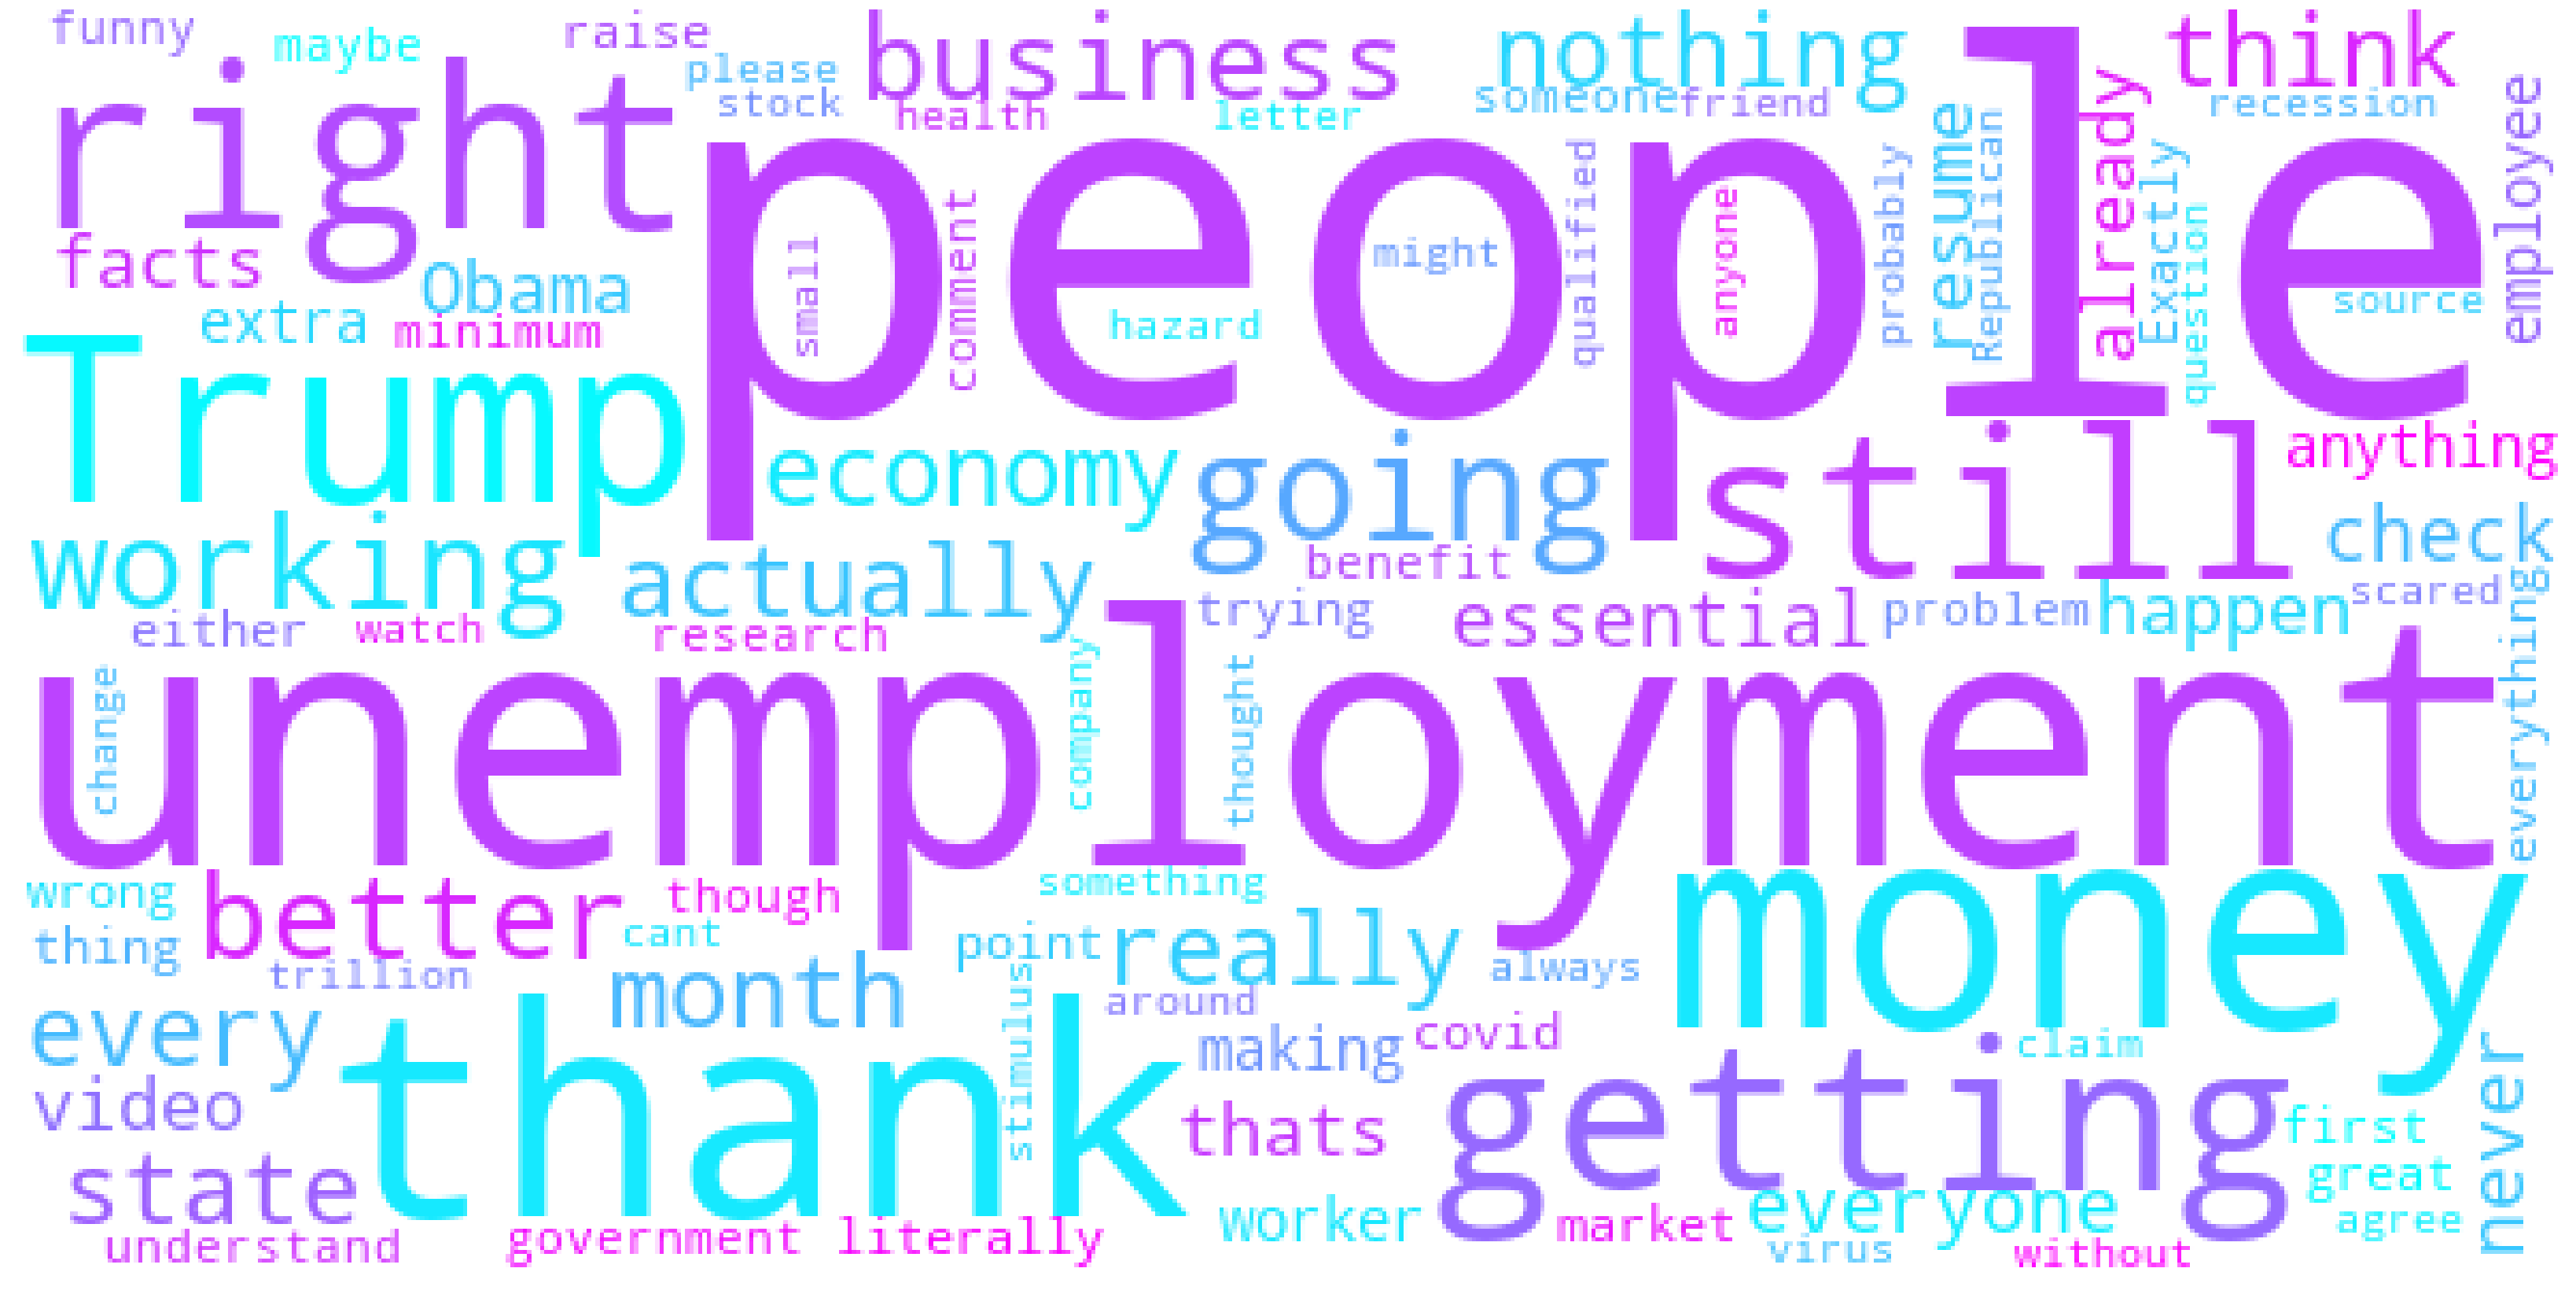

In [15]:
'''word cloud'''

plot_word_cloud(une_alph)

In [16]:
'''using textblob to analyze polarity and subjectivity'''

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

unemployment_frame['polarity'] = unemployment_frame['text'].apply(pol)
unemployment_frame['subjectivity'] = unemployment_frame['text'].apply(sub)

print(unemployment_frame)

                             name  \
0            Heather MacIvor Moul   
1                           Peace   
2            Heather MacIvor Moul   
3     Cathryn Patterson · Creator   
4               user1156407460130   
...                           ...   
1893            user2471415992805   
1894                   Steve Mung   
1895                         Tesa   
1896                    Vungh Kim   
1897                    Vungh Kim   

                                                   text  date  \
0                            cannot hear you bc lashes.   4-8   
1     If you close your eyes they turn all the way d...   4-8   
2                                             good tip!  4-13   
3                                            thank you!  4-13   
4     Lol stop she’s giving good tips and looks so g...  4-19   
...                                                 ...   ...   
1893  Ben Sasse, Rick Scott, Tim Scott, and Lindsey ...   5-8   
1894      Anybody with a 🧠 saw this

Polarity Distribution: 


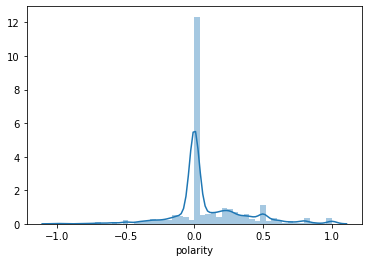

In [17]:
print('Polarity Distribution: ')
sns.distplot(unemployment_frame['polarity']);

Subjectivity Distribution: 


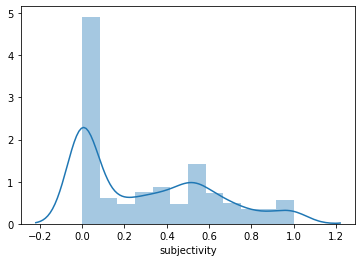

In [18]:
print('Subjectivity Distribution: ')
sns.distplot(unemployment_frame['subjectivity'])

Bivariate Distribution: 


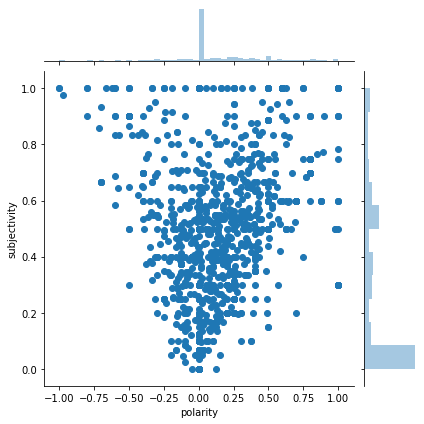

In [19]:
print('Bivariate Distribution: ')
sns.jointplot(x=unemployment_frame.polarity, y=unemployment_frame.subjectivity);

Subjectivity Pie Chart: 


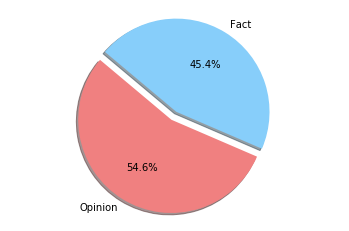

In [20]:
print('Subjectivity Pie Chart: ')
subpie(unemployment_frame.subjectivity,0.15)

Polarity Pie Chart: 


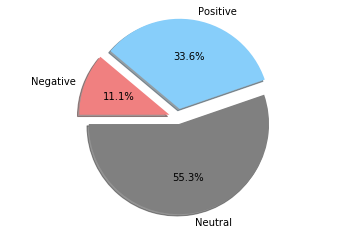

In [21]:
print('Polarity Pie Chart: ')
polplot(unemployment_frame.polarity,[0.1,-0.1]);

In [22]:
#unnesting the text prep and storing in new column to use in document term matrix and polarization + subjectivity
comment_ready = []
for i in unemployment_frame['text_prep']:
    s = " ".join(str(x) for x in i)
    comment_ready.append(s)
unemployment_frame['comment_ready'] = comment_ready

Subjectivity Pie Chart: 


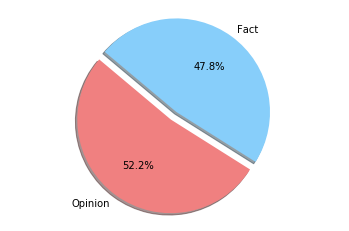

Polarity Pie Chart: 


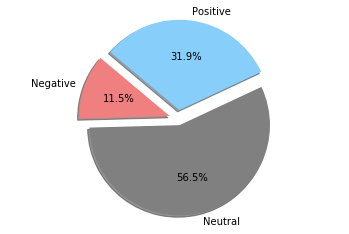

In [23]:
#iterating textblob again with cleaner data

'''using textblob to analyze polarity and subjectivity'''

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

unemployment_frame['polarity_new'] = unemployment_frame['comment_ready'].apply(pol)
unemployment_frame['subjectivity_new'] = unemployment_frame['comment_ready'].apply(sub)

print('Subjectivity Pie Chart: ')
subpie(unemployment_frame.subjectivity_new,0.15)

print('Polarity Pie Chart: ')
polplot(unemployment_frame.polarity_new,[0.1,-0.1]);

## Intuitions - Unemployment

**Word Frequency:**

    Word Frequency is critical in developing our hypotheses. Both unigrams and bigrams had positive results while trigrams had interesting results, with a slightly different perspective. Trump, taxes, unemployment, and money are important frequent terms in understanding issues users are experiencing. Bigrams are much more insightful. Almost every phrase is meaningful. Trigrams are slightly less insightful but provide a different perspective. Frquent trigrams are online digital marketing and more than a couple include Trump. It is clear the uncertainty of the stock market is a concern evident in all frequency analyses.
    Lexical diversity is low (in comparison to large text documents) at 35%. This is expected from a social media platform.
    It is important to understand the concerns of users regarding unemployment given events over the last few months. Coronavirus, quarantine, economic decline, the stock market, political polarization, the upcoming election, unemployment benefits, the stimulus check, and general frustration are evident in the frequency analysis.


**Distribution:**

    Subjectivity resembles a poisson distribution with lambda equal to one. This is useful in calculating Maximum A. Posteriori and interpreting Bayesian probabilities down the road. Polarity resembles a stable distribution of alpha equal to 0.5.

**Polarity and Subjectivity Discussion:**

    Polarity is labeled -1 to 1. -1 as highly negative and 1 as highly positive, 0 as neutral.
    Subjectivity is labeled 0 to 1. 0 as fact and 1 as opinionated.
    
    Subjectivity is split into opinion and fact with a value above 0.15 labeled as opinion. Opinion at 52.2% and fact at 47.8%.
    
    Polarity is split into three categories with the thresholds set at 0.1 and -0.1. Above a 0.1 indicating positive and -0.1 indicating negative. Values inbetween are labeled neutral. Under these conditions, 11.5% was negative polarity, 31.9% positive, and 56.5% neutral. 

    Typically, social media content is expected to be more subjective and polar than the results achieved. There are a few possible issues. 

    1. TikTok users are generally of a younger demographic. The platform encourages more tags of other users to share the video, versus commenting on the video to be heard. These comments fall into neutral.


    2. As TikTok users are of a younger age, they tend to use slang more often, with incomplete sentences and grammatical errors. This could led the Textblob model to categorize more neutral or miscategorize data points.


    3. Comments including just emoticons fall into neutral. 


    4. Users discussing political topics tend to speak matter of factually to assert their opinion. This leads to a higher 'Fact' categorization.
    
    Cleaning the data further into the comment_ready column (versus the unfiltered text column) of the dataframe did not impact polarity or subjectivity results significantly (2% difference in polarity, 1% in subjectivity).

    For these reasons, the polarity threshold is set to be extra sensitive (0.1) to notions of positivity and negativity. The subjectivity threshold is set to (0.15) for extra sensitivity as well.
    
    Combining polarity and subjectivity measurements will help us indicate if the comment's sentiment is in agreement with the topic or in disagreement. This will be performed after topic modeling.

**Why these visualizations:** 

    Plotting frequency helps see the most frequent words and the marginal differences between them. Seeing a correlation between the frequencies of different words, bigrams, and other sets of bigrams helps form a hypothesis and a notion of the data.

    Plotting histogram distributions alone helps gain an idea of how the data is distributed. The joint plot helps visualize the correlation between both variables. Understanding the difference between the distributions and the correlation helps deduce that subjective may not be polar, and polar may not be subjective.

    The pie chart is useful in understanding the ratios of each. It also allows sensitivity analysis of the polarization and subjectivity thresholds.

    Given the platform, Social Network Analysis (SNA) is not a marginally beneficial analysis on the TikTok platform. Without reliable user data, SNA would achieve minimal results. Most users use emjois, fake names, and fake information on the platform, with the majority of users being of a young age. Users interacting with the trending hashtags we collected are believed to be of a slightly older demographic than the average TikTok user because the trend is relevant to government policies with direct impact on their current day-to-day life.

**Hypotheses (Regarding Unemployment):**

1. Users are dissatisfied with disbursement time/application processing time.
2. Users are having difficulty gaining employment.
3. Essential workers feel undervalued as unemployment pays more.

# Stimulus Check Data Exploration

In [24]:
'''gather basic information'''

print(stimulus_frame.info())

#preview data
print(stimulus_frame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 3 columns):
name    2913 non-null object
text    2913 non-null object
date    2913 non-null object
dtypes: object(3)
memory usage: 68.4+ KB
None
                   name                                               text  \
0  HI if you’re viewing  lmao bruh I’m smacked and I watched this and c...   
1         Ed Edd n Eddy                                     I felt that 💀💀   
2                    <3                                      @thugg_waffle   
3                     🦈                             This is the best video   
4            Ian Daniel                                               Same   

   date  
0  4-19  
1  4-21  
2  4-27  
3  4-27  
4  4-28  


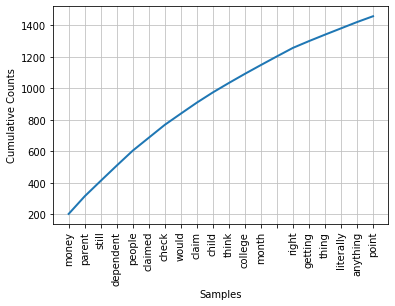

AxesSubplot(0.125,0.125;0.775x0.755)
Top Ten Most Common Words: [('money', 202), ('parent', 112), ('still', 98), ('dependent', 97), ('people', 95), ('claimed', 82), ('check', 82), ('would', 71), ('claim', 70), ('child', 65)]
Ten Least Common Words: ['smacked', 'LEVEL', 'thuggwaffle', 'plotline', 'iykyk', 'heaven', 'cleaning', 'Shoot', 'Ongggg', 'along']
lexical diversity:  0.3180407502361355


In [25]:
'''Word Frequency Analysis'''

#tokenize, lowercase, lemmatize, remove stop words
stimulus_tokens = prep(stimulus_frame['text'])

#add tokens as a new column ('text_prep') to dataframe
stimulus_frame['text_prep'] = stimulus_tokens

#remove anything not alphabetical
stimulus_alph = alph(stimulus_tokens)

#fetch word frequencies
stim_freq_list, stim_not_freq_list, stim_freq_chart = freqChart(stimulus_alph)

#print results
print(stim_freq_chart)

#repeat but with bigrams for more insight
print('Top Ten Most Common Words:',stim_freq_list)
print('Ten Least Common Words:',stim_not_freq_list)
print('lexical diversity: ',lexical_diversity(stimulus_alph))

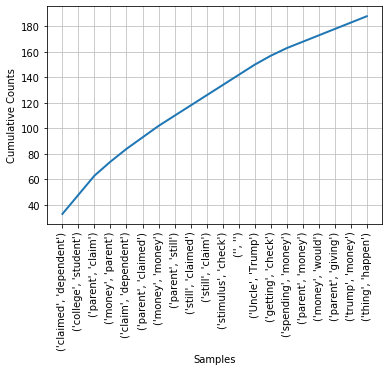

AxesSubplot(0.125,0.125;0.775x0.755)


In [26]:
'''Word Frequency Analysis with Bigrams'''

stim_bigrams = list(nltk.bigrams(stimulus_alph))
stim_bigrams_freq_list, stim_bigrams_uncommon, stim_bigrams_graph = freqChart(stim_bigrams)
print(stim_bigrams_graph)

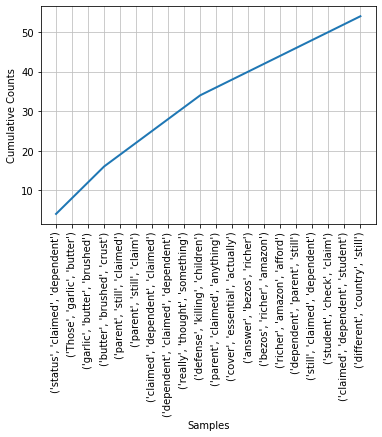

AxesSubplot(0.125,0.125;0.775x0.755)


In [65]:
'''word frequency analysis with trigrams'''

#repeat but with trigrams for more insight
stim_trigrams = list(nltk.trigrams(stimulus_alph))
stim_trigrams_freq_list, stim_trigrams_uncommon, stim_trigrams_graph = freqChart(stim_trigrams)
print(stim_trigrams_graph)

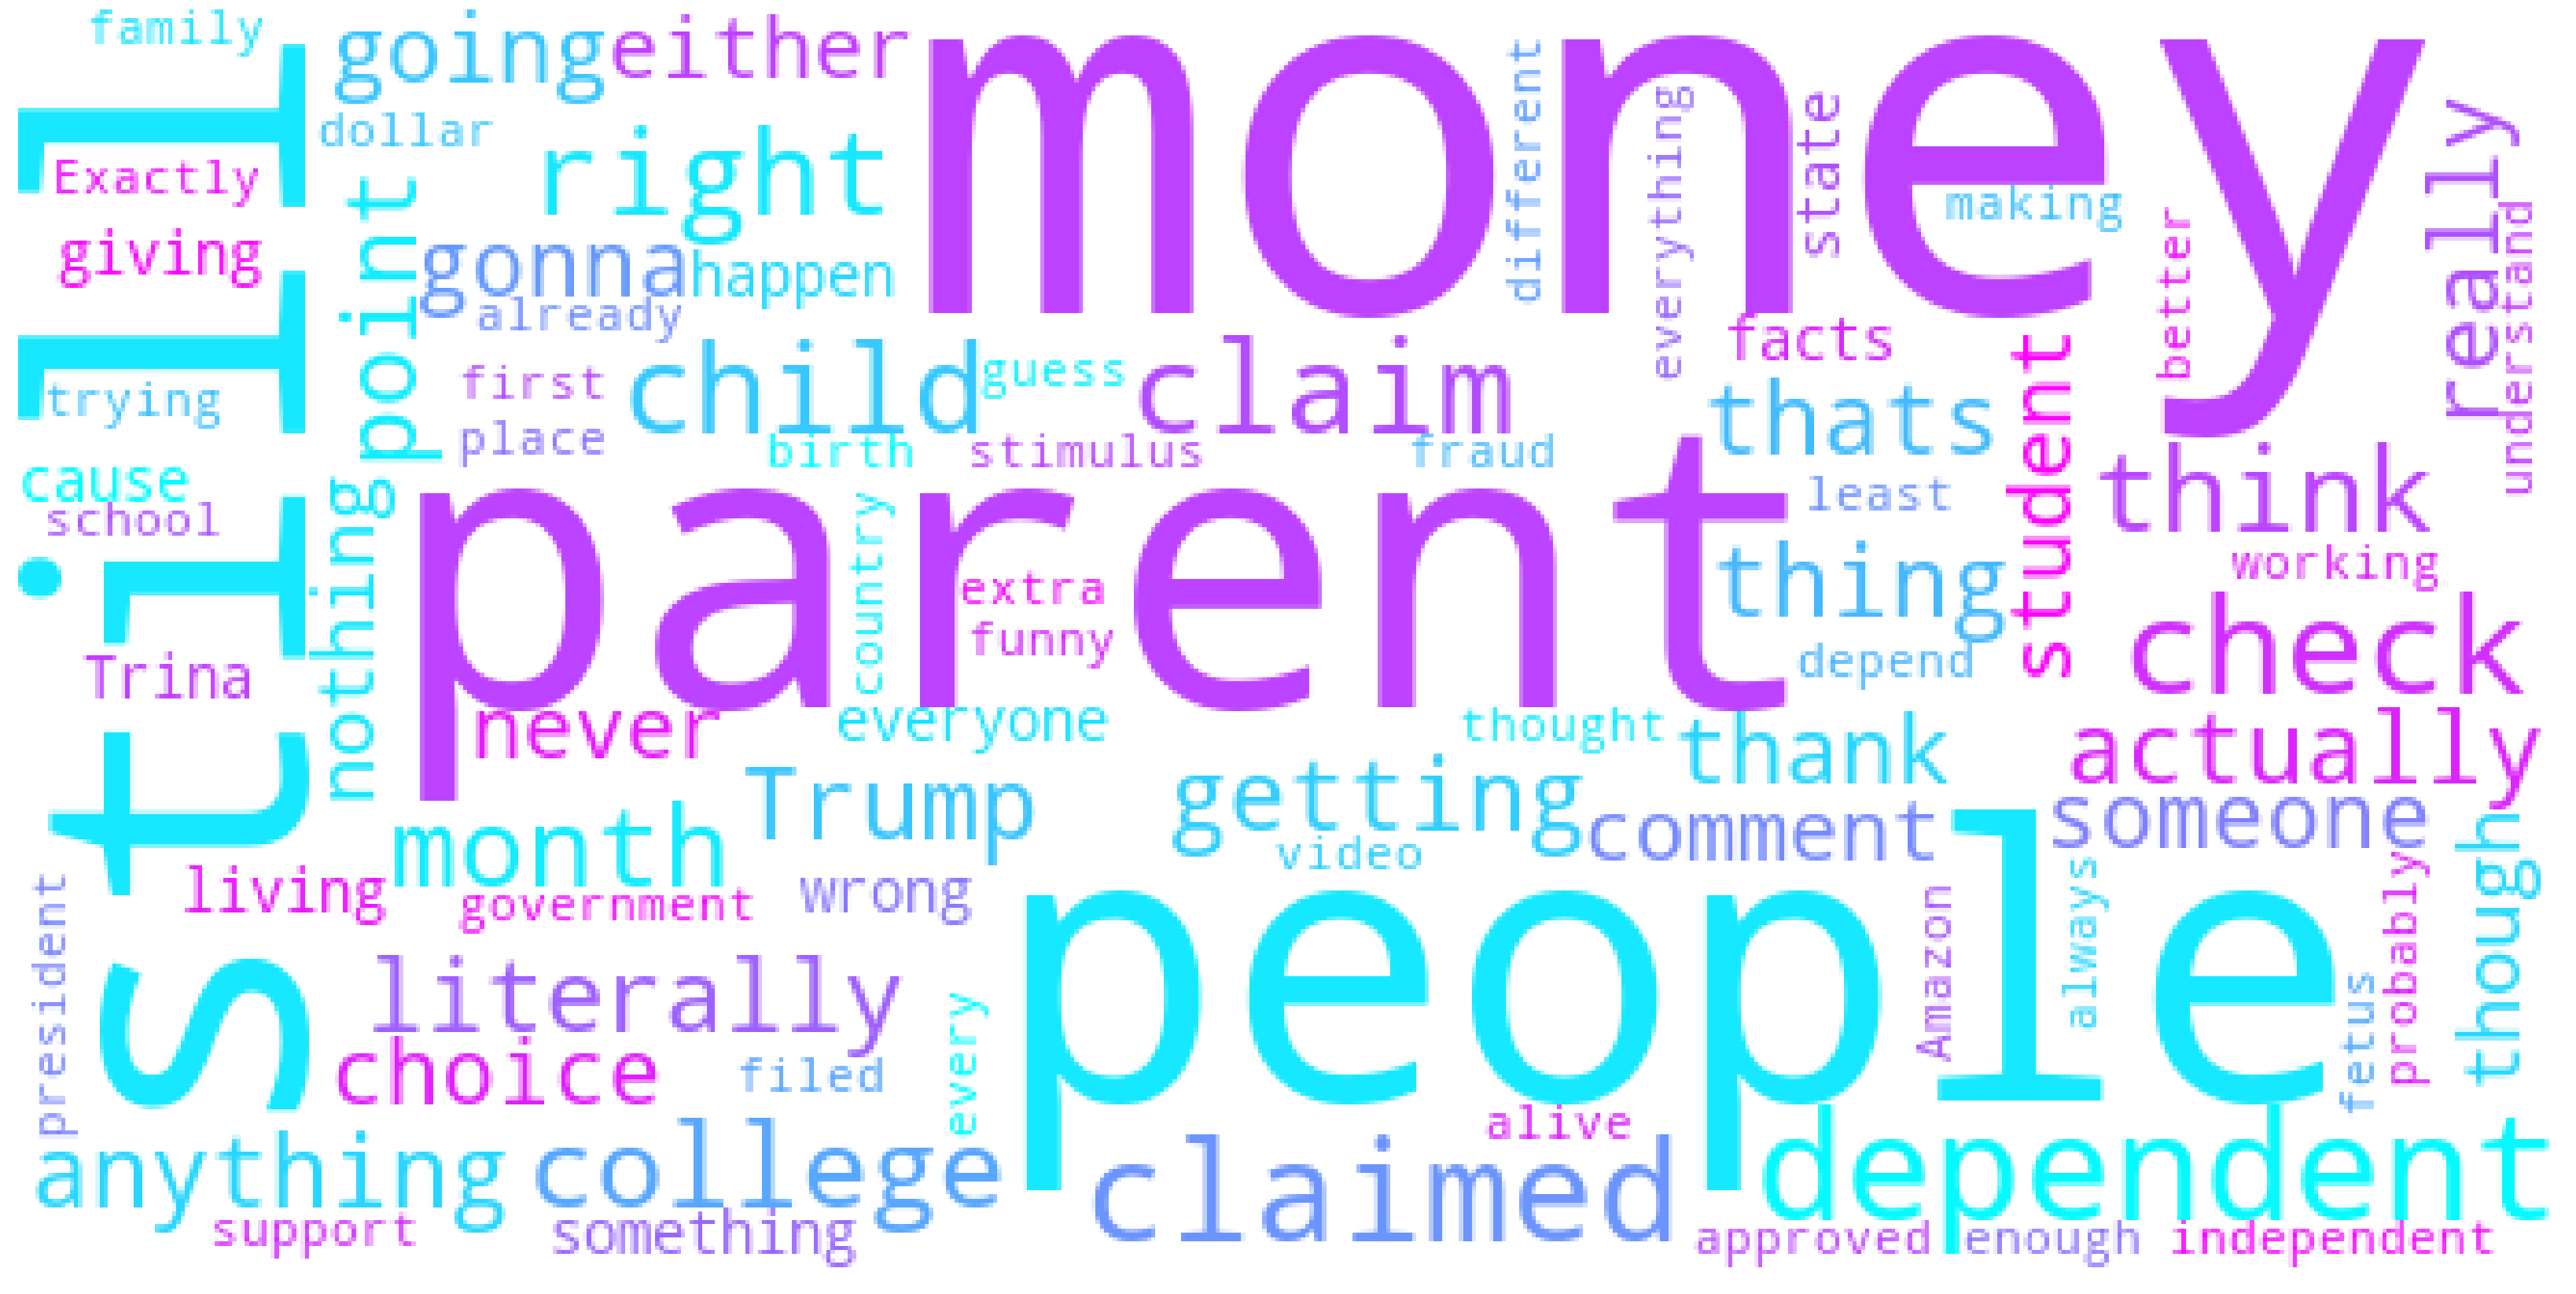

In [27]:
'''word cloud'''

plot_word_cloud(stimulus_alph)

In [28]:
'''using textblob to analyze polarity and subjectivity'''

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

stimulus_frame['polarity'] = stimulus_frame['text'].apply(pol)
stimulus_frame['subjectivity'] = stimulus_frame['text'].apply(sub)

print(stimulus_frame)

                      name                                               text  \
0     HI if you’re viewing  lmao bruh I’m smacked and I watched this and c...   
1            Ed Edd n Eddy                                     I felt that 💀💀   
2                       <3                                      @thugg_waffle   
3                        🦈                             This is the best video   
4               Ian Daniel                                               Same   
...                    ...                                                ...   
2908      Vanessa Vermette              You’re lucky you’re even getting that   
2909          Ashley Lewis                                  @destinycoffman06   
2910               BooBear  I think it’ll work he should send u double now...   
2911           Kayla Reece                                    @thatcatladyamy   
2912      themidnightmeggz                                   @justyn'sjourney   

      date                 

Polarity Distribution: 


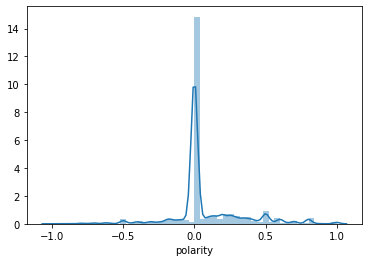

In [29]:
print('Polarity Distribution: ')
sns.distplot(stimulus_frame['polarity']);

Subjectivity Distribution: 


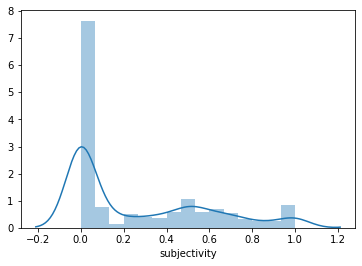

In [30]:
print('Subjectivity Distribution: ')
sns.distplot(stimulus_frame['subjectivity']);

Bivariate Distribution: 


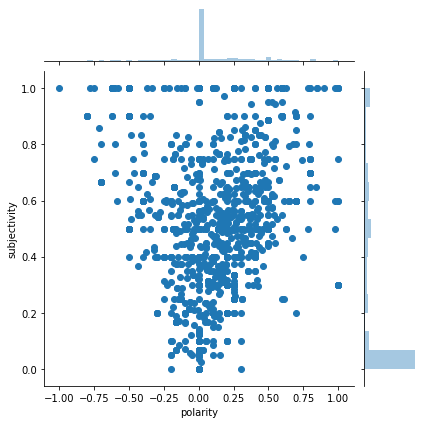

In [31]:
print('Bivariate Distribution: ')
sns.jointplot(x=stimulus_frame.polarity, y=stimulus_frame.subjectivity);

Subjectivity Pie Chart: 


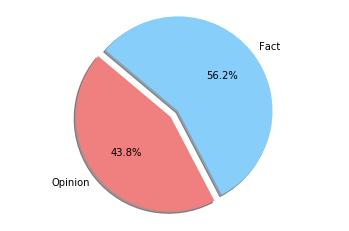

In [32]:
print('Subjectivity Pie Chart: ')
subpie(stimulus_frame.subjectivity,0.15);

Polarity Pie Chart: 


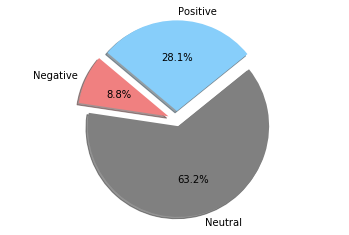

In [33]:
print('Polarity Pie Chart: ')
polplot(stimulus_frame.polarity,[0.1,-0.1]);

In [34]:
#unnesting the text prep and storing in new column to use in document term matrix
comment_ready = []
for i in stimulus_frame['text_prep']:
    s = " ".join(str(x) for x in i)
    comment_ready.append(s)
stimulus_frame['comment_ready'] = comment_ready

## Intuitions - Stimulus

**Word Frequency:**

    Word Frequency is critical in developing our hypotheses. Both unigrams and bigrams had positive results while trigrams provided redundant or randomized results. Parents, claimed, Trump, money, Jeff Bezos, rich, and spending money are common words seen between a variety of different phrases. Parents are a frequent focus between unigrams, bigrams, and trigrams. Frequent trigrams involve Jeff Bezos getting richer and students being claimed as dependents. The frequency of these phrases will reflect in hypotheses deduction.
    Lexical diversity is low (in comparison to large text documents) at 31%. This is expected from a social media platform.
    It is important to understand the concerns of users regarding unemployment given events over the last few months. Coronavirus, quarantine, economic decline, the stock market, political polarization, the upcoming election, unemployment benefits, the stimulus check, and general frustration are evident in the frequency analysis.


**Distribution:**

    Subjectivity resembles a poisson distribution with lambda equal to one. This is useful in calculating Maximum A. Posteriori and interpreting Bayesian probabilities down the road. Polarity resembles a stable distribution of alpha equal to 0.5.

**Polarity and Subjectivity Discussion:**

    Polarity is labeled -1 to 1. -1 as highly negative and 1 as highly positive, 0 as neutral.
    Subjectivity is labeled 0 to 1. 0 as fact and 1 as opinionated.
    
    Subjectivity is split into opinion and fact with a value above 0.15 labeled as opinion. Opinion at 43% and fact at 56%.
    
    Polarity is split into three categories with the thresholds set at 0.1 and -0.1. Above a 0.1 indicating positive and -0.1 indicating negative. Values inbetween are labeled neutral. Under these conditions, 9% was negative polarity, 28% positive, and 56.5% neutral. 

    Typically, social media content is expected to be more subjective and polar than the results achieved. There are a few possible issues. 

    1. TikTok users are generally of a younger demographic. The platform encourages more tags of other users to share the video, versus commenting on the video to be heard. These comments fall into neutral.


    2. As TikTok users are of a younger age, they tend to use slang more often, with incomplete sentences and grammatical errors. This could led the Textblob model to categorize more neutral or miscategorize data points.


    3. Comments including just emoticons fall into neutral. 


    4. Users discussing political topics tend to speak matter of factually to assert their opinion. This leads to a higher 'Fact' categorization.

    For these reasons, the polarity threshold is set to be extra sensitive (0.1) to notions of positivity and negativity. The subjectivity threshold is set to (0.15) for extra sensitivity as well.
    
    Combining polarity and subjectivity measurements will help us indicate if the comment's sentiment is in agreement with the topic or in disagreement. This will be performed after topic modeling.

**Why these visualizations (redundant):** 

    Plotting frequency helps see the most frequent words and the marginal differences between them. Seeing a correlation between the frequencies of different words, bigrams, and other sets of bigrams helps form a hypothesis and a notion of the data.

    Plotting histogram distributions alone helps gain an idea of how the data is distributed. The joint plot helps visualize the correlation between both variables. Understanding the difference between the distributions and the correlation helps deduce that subjective may not be polar, and polar may not be subjective.

    The pie chart is useful in understanding the ratios of each. It also allows sensitivity analysis of the polarization and subjectivity thresholds.

    Given the platform, Social Network Analysis (SNA) is not a marginally beneficial analysis on the TikTok platform. Without reliable user data, SNA would achieve minimal results. Most users use emjois, fake names, and fake information on the platform, with the majority of users being of a young age. Users interacting with the trending hashtags we collected are believed to be of a slightly older demographic than the average TikTok user because the trend is relevant to government policies with direct impact on their current day-to-day life.

**Hypotheses (regarding IRS Stimulus Check Policy):**
1. Many youth have been claimed as dependent by their parents, meaning they do not receive money and their parents receive $1200, despite them not actually being dependents.
2. Dissatisfaction with how tax policies apply (or don't) to Jeff Bezos and Amazon.

# USPS Data Exploration

In [35]:
'''gather basic information'''
print(usps_frame.info())

#preview data
print(usps_frame.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335 entries, 0 to 1334
Data columns (total 3 columns):
name    1335 non-null object
text    1335 non-null object
date    1335 non-null object
dtypes: object(3)
memory usage: 31.4+ KB
None
                  name                                               text  \
0  U.S. Postal Service  Alright that’s pretty cool, how do we apply th...   
1                Alvez                 isn't Trump gonna dissolve y'all??   
2                C.Erk                                             Dead 😂   
3    UhaveAlotOfTalent  Hopefully pos postal service private is way be...   
4                 Andy  Honestly if showed this to trump supporters th...   

   date  
0  5-13  
1  5-14  
2  5-14  
3  5-14  
4  5-14  


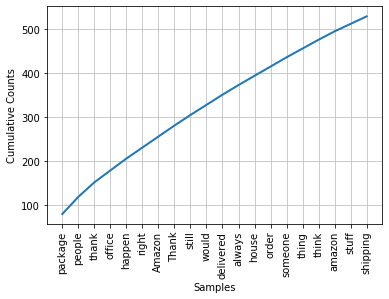

AxesSubplot(0.125,0.125;0.775x0.755)
Top Ten Most Common Words: [('package', 80), ('people', 39), ('thank', 33), ('office', 27), ('happen', 27), ('right', 25), ('Amazon', 25), ('Thank', 25), ('still', 24), ('would', 23)]
Ten Least Common Words: ['Alright', 'Trump', 'dissolve', 'yall', 'showed', 'supporter', 'bankrupt', 'million', 'dollar', 'misuse']
lexical diversity:  0.4217071791972866


In [36]:
'''Word Frequency Analysis'''

#tokenize, lowercase, lemmatize, remove stop words
usps_tokens = prep(usps_frame['text'])

#add tokens as a new column ('text_prep') to dataframe
usps_frame['text_prep'] = usps_tokens

#remove anything not alphabetical
usps_alph = alph(usps_tokens)

#fetch word frequencies
usps_freq_list, usps_not_freq_list, usps_freq_chart = freqChart(usps_alph)

#print results
print(usps_freq_chart)
print('Top Ten Most Common Words:',usps_freq_list)
print('Ten Least Common Words:',usps_not_freq_list)
print('lexical diversity: ',lexical_diversity(usps_alph))

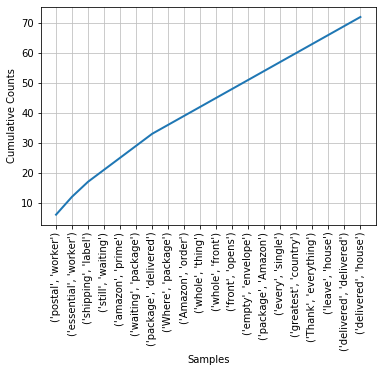

AxesSubplot(0.125,0.125;0.775x0.755)


In [37]:
'''Word Frequency Analysis with Bigrams'''

#repeat but with bigrams for more insight
usps_bigrams = list(nltk.bigrams(usps_alph))
usps_bigrams_freq_list, usps_bigrams_uncommon, usps_bigrams_graph = freqChart(usps_bigrams)
print(usps_bigrams_graph)

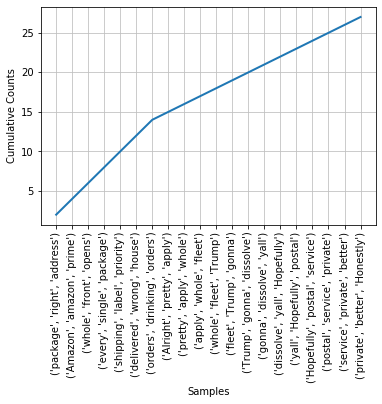

AxesSubplot(0.125,0.125;0.775x0.755)


In [66]:
'''word frequency analysis with trigrams'''

#repeat but with trigrams for more insight
usps_trigrams = list(nltk.trigrams(usps_alph))
usps_trigrams_freq_list, usps_trigrams_uncommon, usps_trigrams_graph = freqChart(usps_trigrams)
print(usps_trigrams_graph)

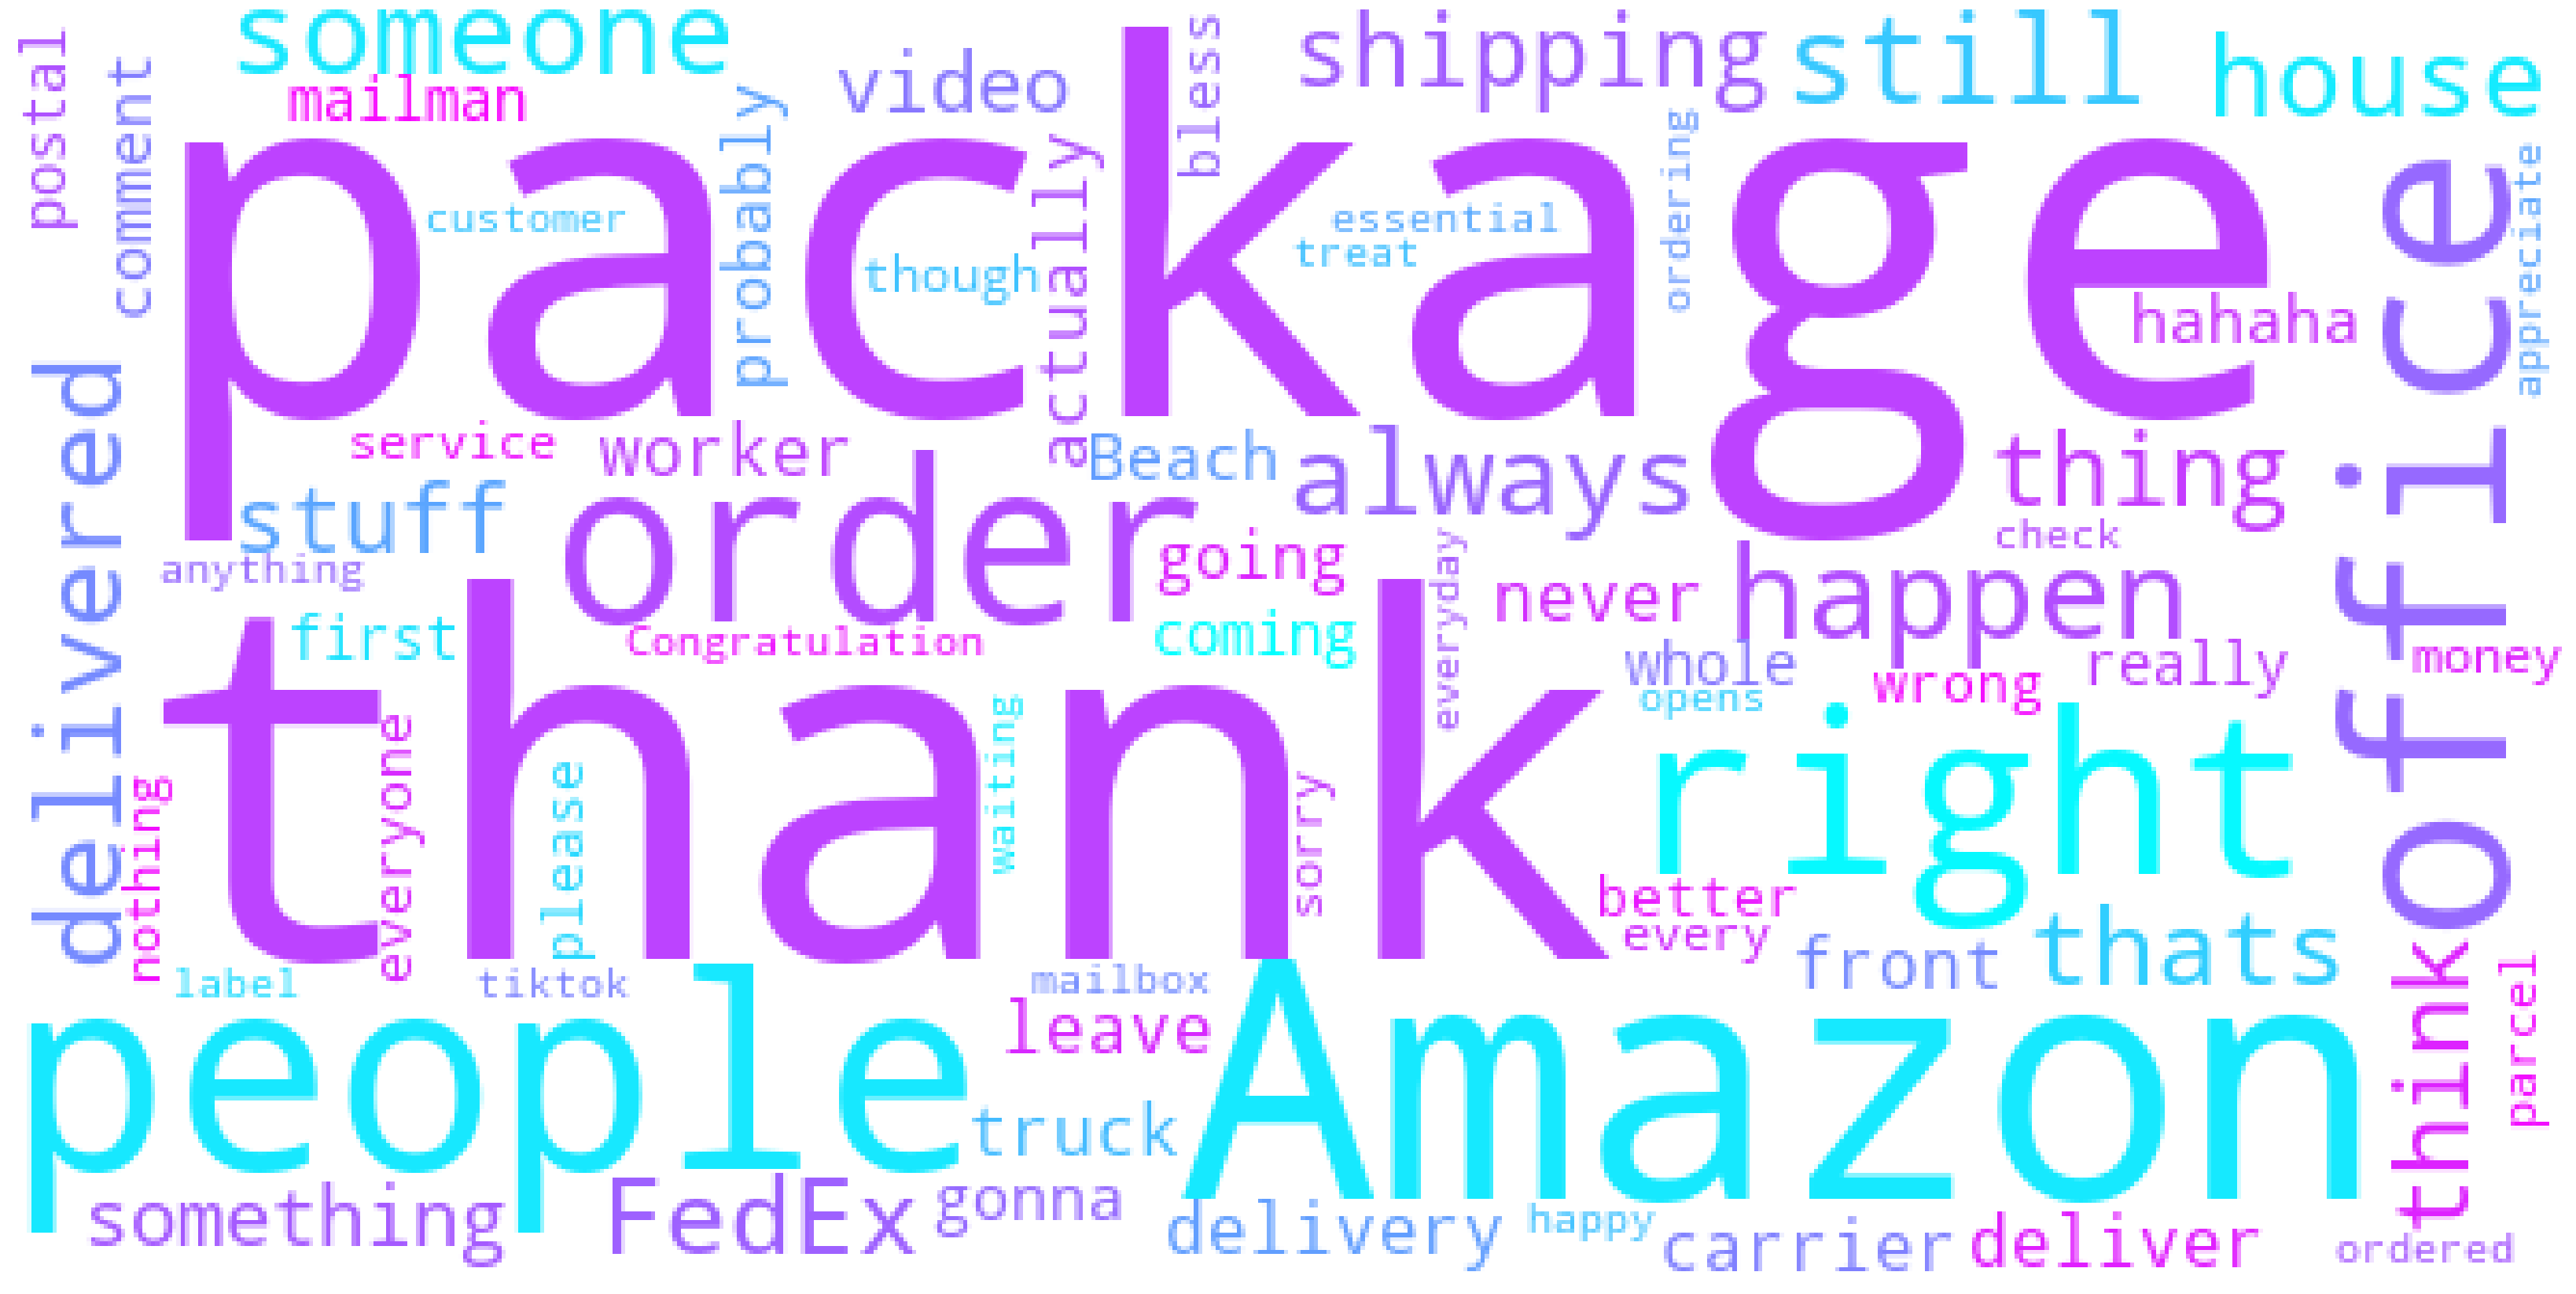

In [38]:
'''word cloud'''

plot_word_cloud(usps_alph)

In [39]:
'''using textblob to analyze polarity and subjectivity'''

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

usps_frame['polarity'] = usps_frame['text'].apply(pol)
usps_frame['subjectivity'] = usps_frame['text'].apply(sub)

print(usps_frame)

                           name  \
0           U.S. Postal Service   
1                         Alvez   
2                         C.Erk   
3             UhaveAlotOfTalent   
4                          Andy   
...                         ...   
1330        Zoe Kraft Kreations   
1331  Family In Bloom · Creator   
1332  Family In Bloom · Creator   
1333                      AlmaF   
1334                        a ♡   

                                                   text     date  \
0     Alright that’s pretty cool, how do we apply th...     5-13   
1                    isn't Trump gonna dissolve y'all??     5-14   
2                                                Dead 😂     5-14   
3     Hopefully pos postal service private is way be...     5-14   
4     Honestly if showed this to trump supporters th...     5-14   
...                                                 ...      ...   
1330  Why not notify the post office to hold ALL you...   2d ago   
1331  Because we get deliveries fro

Polarity Distribution: 


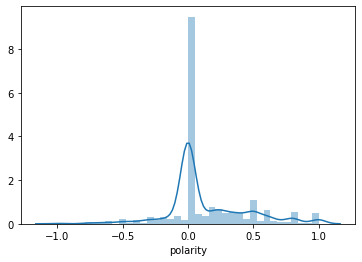

In [40]:
print('Polarity Distribution: ')
sns.distplot(usps_frame['polarity']);

Subjectivity Distribution: 


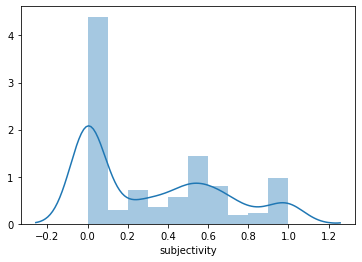

In [41]:
print('Subjectivity Distribution: ')
sns.distplot(usps_frame['subjectivity']);

Bivariate Distribution: 


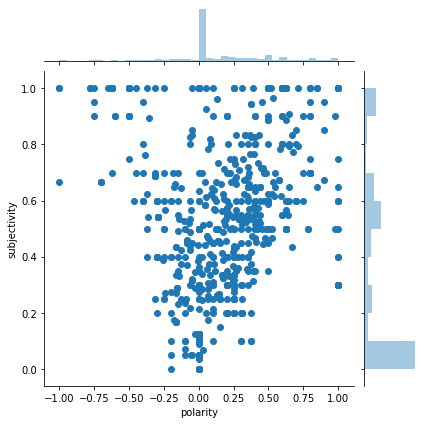

In [42]:
print('Bivariate Distribution: ')
sns.jointplot(x=usps_frame.polarity, y=usps_frame.subjectivity);

Subjectivity Pie Chart: 


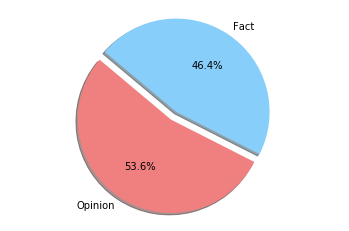

In [43]:
print('Subjectivity Pie Chart: ')
subpie(usps_frame.subjectivity,0.15);

Polarity Pie Chart: 


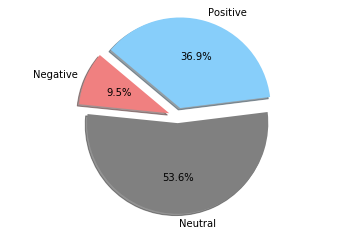

In [44]:
print('Polarity Pie Chart: ')
polplot(usps_frame.polarity,[0.1,-0.1]);

In [45]:
#unnesting the text prep and storing in new column to use in document term matrix and polarization + subjectivity
comment_ready = []
for i in usps_frame['text_prep']:
    s = " ".join(str(x) for x in i)
    comment_ready.append(s)
usps_frame['comment_ready'] = comment_ready

## Intuitions - USPS

**Word Frequency:**

    Word Frequency is critical in developing our hypotheses. Unigrams had positive results while bigrams and trigrams had interesting results, but not entirely helpful due to the low cumulative count. Essential workers, packaging, Amazon, shipping, thank you, empty envelope, dissolve, and privatize are insightful terms that frequent the data. 
    Lexical diversity is slightly higher than the other data sets at 42%. This indicates a higher variety of words are used regarding usps content. With a larger vocabulary, topic modeling may also be more diverse.
    It is important to understand the concerns of users regarding unemployment given events over the last few months. Coronavirus, quarantine, economic decline, the stock market, political polarization, the upcoming election, unemployment benefits, the stimulus check, and general frustration are evident in the frequency analysis.


**Distribution:**

    Subjectivity resembles a poisson distribution with lambda equal to one. This is useful in calculating Maximum A. Posteriori and interpreting Bayesian probabilities down the road. Polarity resembles a stable distribution of alpha equal to 0.5. The distributions of all three datasets are almost identical. Considering they most likely intersect topics, the topic model will benefit from modeling all three datasets.

**Polarity and Subjectivity Discussion:**

    Polarity is labeled -1 to 1. -1 as highly negative and 1 as highly positive, 0 as neutral.
    Subjectivity is labeled 0 to 1. 0 as fact and 1 as opinionated.
    
    Subjectivity is split into opinion and fact with a value above 0.15 labeled as opinion. Opinion at 53% and fact at 46%.
    
    Polarity is split into three categories with the thresholds set at 0.1 and -0.1. Above a 0.1 indicating positive and -0.1 indicating negative. Values inbetween are labeled neutral. Under these conditions, 9.5% was negative polarity, 37% positive, and 56.5% neutral. 

    Typically, social media content is expected to be more subjective and polar than the results achieved. There are a few possible issues. 

    1. TikTok users are generally of a younger demographic. The platform encourages more tags of other users to share the video, versus commenting on the video to be heard. These comments fall into neutral.


    2. As TikTok users are of a younger age, they tend to use slang more often, with incomplete sentences and grammatical errors. This could led the Textblob model to categorize more neutral or miscategorize data points.


    3. Comments including just emoticons fall into neutral. 


    4. Users discussing political topics tend to speak matter of factually to assert their opinion. This leads to a higher 'Fact' categorization.
    
    For these reasons, the polarity threshold is set to be extra sensitive (0.1) to notions of positivity and negativity. The subjectivity threshold is set to (0.15) for extra sensitivity as well.
    
    Combining polarity and subjectivity measurements will help us indicate if the comment's sentiment is in agreement with the topic or in disagreement. This will be performed after topic modeling.

**Why these visualizations (redundant):** 

    Plotting frequency helps see the most frequent words and the marginal differences between them. Seeing a correlation between the frequencies of different words, bigrams, and other sets of bigrams helps form a hypothesis and a notion of the data.

    Plotting histogram distributions alone helps gain an idea of how the data is distributed. The joint plot helps visualize the correlation between both variables. Understanding the difference between the distributions and the correlation helps deduce that subjective may not be polar, and polar may not be subjective.

    The pie chart is useful in understanding the ratios of each. It also allows sensitivity analysis of the polarization and subjectivity thresholds.

    Given the platform, Social Network Analysis (SNA) is not a marginally beneficial analysis on the TikTok platform. Without reliable user data, SNA would achieve minimal results. Most users use emjois, fake names, and fake information on the platform, with the majority of users being of a young age. Users interacting with the trending hashtags we collected are believed to be of a slightly older demographic than the average TikTok user because the trend is relevant to government policies with direct impact on their current day-to-day life.

**Hypotheses (USPS speculation):**
1. Amazon delivers faster, with more care. 
2. USPS should be privatized.
3. Users are still waiting on packages.
4. Users are thankful for USPS essential workers.

# Topic Modeling

The topic modeling technique used is Latent Dirichlet Allocation (LDA), specifically tailored for text processing. A Baysian model will build on the distribution plotting earlier, allowing us to see under the hood better. LDA results are also more interpretable in comparison to LSA.

In [46]:
#create a corpus of all three sets
df = pd.DataFrame({'Unemployment':unemployment_frame.comment_ready,'Stimulus':stimulus_frame.comment_ready,'USPS':usps_frame.comment_ready})
df.head()

,Unemployment,Stimulus,USPS
0,cannot hear bc lash .,lmao bruh I ’ smacked I watch completely felt ...,"Alright ’ pretty cool , apply whole fleet ?"
1,If close eye turn way .,I felt 💀 💀,Trump gonna dissolve y'all ? ?
2,good tip !,@thugg_waffle,Dead 😂
3,thank !,This best video,Hopefully po postal service private way better
4,Lol stop ’ giving good tip look great,Same,Honestly showed trump supporter ’ beg fund usps


### Experimentation

In [47]:
#create bag of words model
texts = []
for i in unemployment_frame.comment_ready:
    texts.append(i)
for i in stimulus_frame.comment_ready:
    texts.append(i)
for i in usps_frame.comment_ready:
    texts.append(i)
dataset = [d.split() for d in texts]

In [48]:
#create dictionary parameter
dictionary = corpora.Dictionary(dataset)

#feed b.o.w into corpus form
corpus = [dictionary.doc2bow(text) for text in dataset]

#run lda model
#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.194*"!" + 0.017*"️" + 0.013*"I" + 0.010*"💛" + 0.009*"Yes" + 0.009*"’" + 0.008*"Thank" + 0.008*"🏻" + 0.007*"👏" + 0.007*"❤"'), (1, '0.098*"😂" + 0.033*"🤣" + 0.021*"I" + 0.018*"lol" + 0.017*"😭" + 0.015*"." + 0.011*"get" + 0.010*"🙂" + 0.009*"package" + 0.007*"week"'), (2, '0.063*"’" + 0.062*"." + 0.054*"I" + 0.023*"," + 0.021*"?" + 0.009*"get" + 0.008*"work" + 0.007*"like" + 0.007*"say" + 0.007*"It"'), (3, '0.029*"😅" + 0.015*"?" + 0.015*"," + 0.011*"2020" + 0.009*"class" + 0.008*"*" + 0.008*"’" + 0.007*"feel" + 0.007*"😔" + 0.006*"haha"')]


**LDA with these parameters do not speak much for the data topics. The model currently uses all words to form the topics. Must also remove punctuation A possible remedy is to create a bag of words model only using nouns then experiment with the parameters.**

In [50]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [51]:
noun_tokens = []
for word in texts:
    noun_tokens.append(nouns(word))
dataset = [d.split() for d in noun_tokens]

In [52]:
#create dictionary parameter
dictionary = corpora.Dictionary(dataset)

#feed b.o.w into corpus form
corpus = [dictionary.doc2bow(text) for text in dataset]

#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.045*"’" + 0.025*"😅" + 0.019*"@" + 0.015*"pay" + 0.014*"get" + 0.013*"👏" + 0.012*"child" + 0.011*"check" + 0.010*"claim" + 0.008*"Lol"'), (1, '0.031*"️" + 0.020*"people" + 0.015*"🏻" + 0.014*"Congratulations" + 0.013*"thank" + 0.012*"💛" + 0.012*"🙂" + 0.011*"❤" + 0.010*"\u200d" + 0.010*"🖤"'), (2, '0.063*"’" + 0.027*"money" + 0.025*"time" + 0.024*"work" + 0.021*"tax" + 0.020*"year" + 0.015*"life" + 0.015*"way" + 0.014*"people" + 0.012*"week"'), (3, '0.107*"😂" + 0.038*"🤣" + 0.024*"lol" + 0.021*"😭" + 0.014*"day" + 0.014*"something" + 0.013*"package" + 0.012*"someone" + 0.011*"’" + 0.010*"nothing"')]


**These topics look a little more informative with nouns money, parents, taxes, check, and mail. These are topics were expected. Facts, life, and the emojis are unexpected, yet informative. However, there is plenty of internet slang in these topics that must be filtered out. The next step is to add to the stop words list and filter these terms out.**

In [53]:
stop_words = set(stopwords.words('english'))
#update stop words
add_stop_words = ['like', 'im', 'm', '@', 's', 'thank', 'year', 'i', 'facts', "'", '%', 'lol','know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'yes', 't', 'omg']

updated_stop_words = stop_words.union(add_stop_words)

In [54]:
n=[]
import enchant
d = enchant.Dict("en_US")
for i in noun_tokens:
    i = i.lower()
    comm = t.tokenize(i)
    for c in comm:
        if c not in updated_stop_words:
            eng = d.check(c) # remove emojis
            if eng == True:
                n.append(c)

In [56]:
dataset = [d.split() for d in n]
#run lda model
#feed b.o.w into corpus form
corpus = [dictionary.doc2bow(text) for text in dataset]

#create dictionary parameter
dictionary = corpora.Dictionary(dataset)

#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, update_every=1, passes=80)

print(lda.print_topics())

[(0, '0.052*"work" + 0.046*"tax" + 0.026*"parent" + 0.018*"nothing" + 0.017*"video" + 0.016*"college" + 0.014*"house" + 0.014*"state" + 0.011*"dependent" + 0.011*"guy"'), (1, '0.034*"job" + 0.029*"pay" + 0.023*"amazon" + 0.022*"unemployment" + 0.022*"bill" + 0.020*"someone" + 0.019*"week" + 0.018*"something" + 0.018*"claim" + 0.017*"thanks"'), (2, '0.031*"package" + 0.025*"get" + 0.024*"thing" + 0.024*"life" + 0.023*"mail" + 0.021*"month" + 0.018*"anything" + 0.015*"comment" + 0.015*"home" + 0.013*"ups"'), (3, '0.066*"money" + 0.028*"way" + 0.025*"day" + 0.021*"trump" + 0.020*"check" + 0.017*"box" + 0.016*"everyone" + 0.015*"mom" + 0.015*"man" + 0.015*"girl"')]


In [57]:
#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.048*"job" + 0.030*"amazon" + 0.030*"bill" + 0.024*"something" + 0.016*"kid" + 0.016*"order" + 0.015*"go" + 0.015*"family" + 0.014*"help" + 0.013*"mine"'), (1, '0.043*"package" + 0.032*"mail" + 0.022*"box" + 0.022*"thanks" + 0.022*"comment" + 0.022*"video" + 0.020*"child" + 0.018*"state" + 0.018*"ups" + 0.017*"everything"'), (2, '0.079*"work" + 0.043*"way" + 0.042*"get" + 0.035*"unemployment" + 0.034*"trump" + 0.031*"week" + 0.024*"mom" + 0.023*"post" + 0.018*"lot" + 0.017*"beach"'), (3, '0.071*"tax" + 0.046*"pay" + 0.040*"thing" + 0.039*"day" + 0.036*"month" + 0.030*"anything" + 0.028*"claim" + 0.026*"home" + 0.024*".." + 0.023*"girl"'), (4, '0.038*"life" + 0.037*"parent" + 0.029*"someone" + 0.022*"man" + 0.020*"house" + 0.018*"business" + 0.017*"doe" + 0.016*"dependent" + 0.014*"cause" + 0.013*"use"'), (5, '0.108*"money" + 0.032*"check" + 0.028*"nothing" + 0.027*"everyone" + 0.025*"point" + 0.024*"college" + 0.024*"office" + 0.022*"worker" + 0.018*"u" + 0.017*"guy"')]


In [58]:
#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.079*"pay" + 0.047*"nothing" + 0.044*"home" + 0.041*"office" + 0.035*"ups" + 0.030*"part" + 0.024*"use" + 0.022*"economy" + 0.021*"ones" + 0.021*"truck"'), (1, '0.102*"tax" + 0.071*"package" + 0.053*"mail" + 0.045*"check" + 0.040*"claim" + 0.039*"something" + 0.036*"video" + 0.026*"lot" + 0.024*"go" + 0.024*"guy"'), (2, '0.116*"work" + 0.058*"thing" + 0.057*"parent" + 0.034*"child" + 0.031*"worker" + 0.026*"kid" + 0.025*"problem" + 0.025*"dependent" + 0.024*"family" + 0.021*"mine"'), (3, '0.061*"month" + 0.054*"someone" + 0.044*"thanks" + 0.042*".." + 0.036*"state" + 0.034*"everything" + 0.032*"tho" + 0.030*"u" + 0.026*"choice" + 0.024*"make"'), (4, '0.072*"get" + 0.066*"day" + 0.058*"trump" + 0.039*"man" + 0.035*"house" + 0.027*"door" + 0.025*"care" + 0.025*"baby" + 0.022*"stuff" + 0.021*"please"'), (5, '0.184*"money" + 0.069*"life" + 0.062*"unemployment" + 0.040*"girl" + 0.032*"business" + 0.029*"beach" + 0.023*"joke" + 0.019*"country" + 0.015*"husband" + 0.014*"bank"'), (6, '

**The refined nouns model makes significantly more applicable sense. Let's attempt to topic model with both adjectives and nouns. Then decide on the final topic model to choose.**

In [59]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [60]:
adj_noun_tokens = []
for word in texts:
    adj_noun_tokens.append(nouns_adj(word))
dataset = [d.split() for d in noun_tokens]

In [61]:
an = []
for i in adj_noun_tokens:
    i = i.lower()
    comm = t.tokenize(i)
    for c in comm:
        if c not in updated_stop_words:
            eng = d.check(c) # remove emojis
            if eng == True:
                an.append(c)

In [62]:
dataset = [d.split() for d in an]
#run lda model
#feed b.o.w into corpus form
corpus = [dictionary.doc2bow(text) for text in dataset]

#create dictionary parameter
dictionary = corpora.Dictionary(dataset)

#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.026*"horrible" + 0.023*"necessary" + 0.017*"shortfall" + 0.016*"offer" + 0.015*"ways" + 0.015*"bank" + 0.014*"growth" + 0.014*"doe" + 0.013*"save" + 0.013*"percent"'), (1, '0.037*"brain" + 0.022*"turn" + 0.020*"week" + 0.019*"work" + 0.019*"teeth" + 0.019*"welcome" + 0.017*"license" + 0.015*"reviews" + 0.014*"sure" + 0.014*"impressed"'), (2, '0.026*"decision" + 0.024*"schizophrenic" + 0.018*"face" + 0.017*"morse" + 0.015*"unresponsive" + 0.014*"recruiter" + 0.013*"hide" + 0.013*"apt" + 0.012*"incorporate" + 0.009*"f"'), (3, '0.059*"project" + 0.043*"candidates" + 0.030*"ta" + 0.030*"tip" + 0.023*"fair" + 0.021*"aunt" + 0.021*"exact" + 0.020*"language" + 0.019*"buzz" + 0.019*"dear"')]


In [63]:
#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.037*"horrible" + 0.034*"schizophrenic" + 0.033*"necessary" + 0.029*"exact" + 0.028*"language" + 0.020*"long" + 0.018*"stimulate" + 0.018*"try" + 0.014*"solution" + 0.012*"experienced"'), (1, '0.031*"week" + 0.027*"face" + 0.026*"license" + 0.021*"abstinence" + 0.020*"percent" + 0.020*"letter" + 0.017*"govt" + 0.017*"person" + 0.016*"rewrite" + 0.015*"federal"'), (2, '0.060*"candidates" + 0.054*"brain" + 0.042*"ta" + 0.032*"turn" + 0.026*"buzz" + 0.020*"growth" + 0.018*"true" + 0.015*"factor" + 0.012*"makes" + 0.012*"always"'), (3, '0.039*"decision" + 0.034*"fair" + 0.031*"aunt" + 0.030*"teeth" + 0.025*"morse" + 0.022*"sure" + 0.021*"recruiter" + 0.020*"hide" + 0.019*"worry" + 0.018*"incorporate"'), (4, '0.091*"project" + 0.046*"tip" + 0.029*"dear" + 0.025*"offer" + 0.025*"much" + 0.024*"unresponsive" + 0.024*"ways" + 0.024*"reviews" + 0.022*"doe" + 0.018*"hard"'), (5, '0.029*"work" + 0.029*"welcome" + 0.025*"shortfall" + 0.022*"bank" + 0.021*"impressed" + 0.021*"cool" + 0.020*"

In [64]:
#run lda model
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, update_every=1, passes=120)

print(lda.print_topics())

[(0, '0.076*"ta" + 0.061*"schizophrenic" + 0.059*"necessary" + 0.058*"turn" + 0.036*"growth" + 0.032*"true" + 0.029*"please" + 0.026*"huge" + 0.021*"grammar" + 0.020*"fund"'), (1, '0.071*"decision" + 0.051*"buzz" + 0.045*"morse" + 0.044*"offer" + 0.039*"abstinence" + 0.036*"percent" + 0.030*"hard" + 0.025*"f" + 0.021*"monitoring" + 0.020*"plan"'), (2, '0.051*"fair" + 0.046*"aunt" + 0.033*"bank" + 0.031*"cool" + 0.031*"long" + 0.029*"apt" + 0.028*"try" + 0.022*"solution" + 0.022*"background" + 0.021*"important"'), (3, '0.155*"project" + 0.053*"language" + 0.048*"face" + 0.039*"sure" + 0.034*"worry" + 0.030*"person" + 0.027*"role" + 0.025*"inflation" + 0.022*"figuratively" + 0.021*"gym"'), (4, '0.114*"candidates" + 0.053*"teeth" + 0.039*"impressed" + 0.038*"doe" + 0.036*"hide" + 0.035*"letter" + 0.035*"stimulate" + 0.032*"incorporate" + 0.023*"mail" + 0.022*"word"'), (5, '0.077*"tip" + 0.052*"work" + 0.039*"reviews" + 0.035*"save" + 0.030*"interview" + 0.028*"factor" + 0.027*"take" + 0.0

### Final Topic Model

After analyzing interprebility and compatability of the topics with the data, the noun-adjective model at 6 topics fits best after experimentation.

We can label the 6 topics as such:

1. Stimulus Check policy
2. Government satisfaction
3. The upcoming Election
4. Applying for jobs
5. Advice
6. Monetary Concerns

# Sentiment Analysis
Combining Polarity, Sentiment, and Topic Modeling

# Document Summarization